In [3]:
import os
import sys
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pytorch3d
import pytorch3d.io
from pytorch3d.vis.plotly_vis import plot_scene
from tqdm.auto import tqdm

import starter.utils

/opt/miniconda3/envs/learning3d/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# This should print True if you are using your GPU
print("Using GPU:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

Using GPU: False


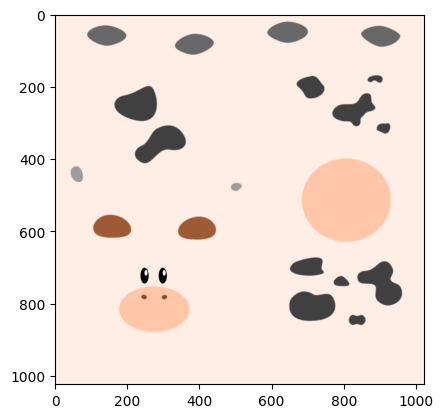

In [8]:
vertices, face_props, text_props = pytorch3d.io.load_obj("data/cow.obj")
faces = face_props.verts_idx
vertices = vertices.unsqueeze(0)
faces = faces.unsqueeze(0)
verts_uvs = text_props.verts_uvs
faces_uvs = face_props.textures_idx

texture_map = plt.imread("data/cow_texture.png")
plt.imshow(texture_map)

In [12]:
textures_uv = pytorch3d.renderer.TexturesUV(
    maps=torch.tensor([texture_map]),
    faces_uvs=faces_uvs.unsqueeze(0),
    verts_uvs=verts_uvs.unsqueeze(0),
).to(device)


In [13]:
meshes = pytorch3d.structures.Meshes(
    verts=vertices, # batched tensor or a list of tensors
    faces=faces,
    textures=textures_uv,
)
meshes = meshes.to(device)  # Move mesh to GPU

In [12]:
image_size = 512

raster_settings = pytorch3d.renderer.RasterizationSettings(image_size=image_size)
rasterizer = pytorch3d.renderer.MeshRasterizer(
    raster_settings=raster_settings,
)
shader = pytorch3d.renderer.HardPhongShader(device=device)
renderer = pytorch3d.renderer.MeshRenderer(
    rasterizer=rasterizer,
    shader=shader,
)

In [17]:
lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)


In [25]:
num_views = 36
R, T = pytorch3d.renderer.look_at_view_transform(
    dist=3,
    elev=0,
    azim=np.linspace(0, 360, num_views, endpoint=False),
)
print("R", R.shape)
print("T", T.shape)
many_cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)
images = renderer(meshes.extend(num_views), cameras=many_cameras, lights=lights)

R torch.Size([36, 3, 3])
T torch.Size([36, 3])


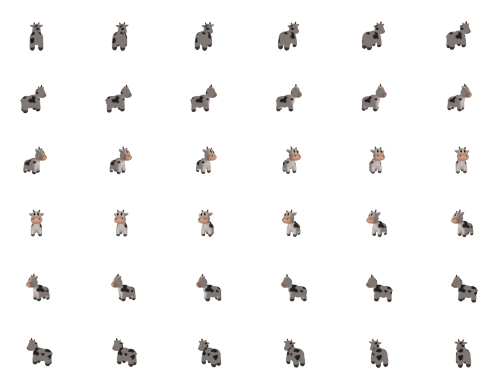

In [26]:
fig, axs = plt.subplots(6, 6)
axs = axs.flatten()
for i, image in enumerate(images):
    ax = axs[i]
    ax.imshow(image.cpu())
    ax.axis("off")

In [30]:
import imageio
# 转换图像格式
my_images = []
for image in images:
    # 转换为numpy数组，只保留RGB通道，转换为0-255范围的uint8类型
    img = (image.cpu().numpy()[0] * 255).astype(np.uint8)
    my_images.append(img)

# 保存GIF
duration = 1000 // 15  # Convert FPS to duration
imageio.mimsave('results/my_gif.gif', my_images, duration=duration, loop=0)

# my_images = images  # List of images [(H, W, 3)]
# duration = 1000 // 15  # Convert FPS (frames per second) to duration (ms per frame)
# imageio.mimsave('results/my_gif.gif', my_images, duration=duratio, loop=0)

In [32]:
# 转换图像格式
my_images = []
for image in images:
    img = image.cpu().numpy()
    img = (img * 255).astype(np.uint8)[:, :, :3]
    my_images.append(img)

# 保存GIF
duration = 1000 // 15  # Convert FPS to duration
imageio.mimsave('results/my_gif.gif', my_images, duration=duration, loop=0)

Retexturing a mesh

In [30]:
from starter.utils import load_cow_mesh
def color_cow_front_to_back():
    # Get the vertices, faces, and textures.
    vertices, faces = load_cow_mesh("data/cow.obj")
    vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    
    # 获取z坐标的最大值和最小值
    # import pdb; pdb.set_trace()
    z_min = vertices[:, 2].min()
    z_max = vertices[:, 2].max()
    
    # 定义前后两种颜色
    color1 = torch.tensor([1.0, 0.0, 0.0], device=device)  # 前面颜色（红色）
    color2 = torch.tensor([0.0, 0.0, 1.0], device=device)  # 后面颜色（蓝色）
    
    # 计算每个顶点的颜色插值权重
    weights = (vertices[0, :, 2] - z_min) / (z_max - z_min)  # Shape: (N_v,)

    colors = (1 - weights[:, None]) * color1 + weights[:, None] * color2  # Shape: (N_v, 3)
    colors = colors.unsqueeze(0)  # Add batch dimension -> (1, N_v, 3)
    # print(colors.shape)
    # 创建新的网格，带有渐变颜色
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(verts_features=colors),
    )
    
    return mesh

# 创建渐变色奶牛
mesh = color_cow_front_to_back()

# 渲染360度视图
num_views = 15
R, T = pytorch3d.renderer.look_at_view_transform(
    dist=5,
    elev=0,
    azim=np.linspace(0, 360, num_views, endpoint=False),
)

cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=R,
    T=T,
    device=device
)

# 渲染
image_size = 512

raster_settings = pytorch3d.renderer.RasterizationSettings(image_size=image_size)
rasterizer = pytorch3d.renderer.MeshRasterizer(
    raster_settings=raster_settings,
)
shader = pytorch3d.renderer.HardPhongShader(device=device)
renderer = pytorch3d.renderer.MeshRenderer(
    rasterizer=rasterizer,
    shader=shader,
)

lights = pytorch3d.renderer.PointLights(location=[[3, 3, -3]], device=device)

images = renderer(mesh.extend(num_views), cameras=cameras, lights=lights)

# 保存GIF
my_images = []
for image in images:
    img = (image.cpu().numpy() * 255).astype(np.uint8)[:, :, :3]
    my_images.append(img)

import imageio

imageio.mimsave('results/gradient_cow.gif', my_images, duration=1000//15)